[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ietheredge/ASAB-2019-MLWS/blob/master/2-UnsupervisedApprocahes-MLWS-ASAB2019-MPIAB.ipynb)

In [15]:
import sys
!{sys.executable} -m pip install --upgrade git+https://www.github.com/jgraving/behavelet.git
!{sys.executable} -m pip install --upgrade pandas
!{sys.executable} -m pip install --upgrade numpy
!{sys.executable} -m pip install --upgrade scipy
!{sys.executable} -m pip install --upgrade umap
!{sys.executable} -m pip install --upgrade scikit-learn

  Cloning https://www.github.com/jgraving/behavelet.git to /tmp/pip-req-build-8s6bzuxc
  Running setup.py bdist_wheel for behavelet ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7eky6or/wheels/01/49/6a/5fc7f66bdfe5ea597bac908e9d97f772dd88f14add4f8caf9c
Successfully built behavelet
  Found existing installation: behavelet 0.0.1
    Uninstalling behavelet-0.0.1:
      Successfully uninstalled behavelet-0.0.1
    100% |████████████████████████████████| 10.5MB 3.4MB/s eta 0:00:01
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2
^C
Operation cancelled by user
    0% |                                | 40kB 3.2MB/s eta 0:00:07^C

Operation cancelled by user
^C
Operation cancelled by user


KeyboardInterrupt: 

In [1]:
from behavelet import wavelet_transform

/home/ngwena-ian/miniconda3/envs/models/lib/python3.6/site-packages/behavelet/morlet.py:26: UserWarning: CuPy was not found, so GPU functionality is unavailable
  warnings.warn('CuPy was not found, so GPU functionality is unavailable')


In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import linalg as LA
import umap
from scipy import ndimage

In [4]:
# file_name = 'time_series.npy
# DATA_DIR = 'data/'
# OUTPUT_DIR = 'output/'
# data_file = os.path.join(DATA_DIR, file_name)

In [5]:
DATA_DIR = '/media/jordan_lab/People/ietheredge/Collaborations/EH-Bats/data'
OUTPUT_DIR = '/media/jordan_lab/People/ietheredge/Collaborations/EH-Bats/results'
file = os.path.join(DATA_DIR, 'Mviv17_60_ACC.csv')

In [6]:
df = pd.read_csv(file, index_col=0)
arr = np.array(df[['X', 'Y', 'Z']]).T

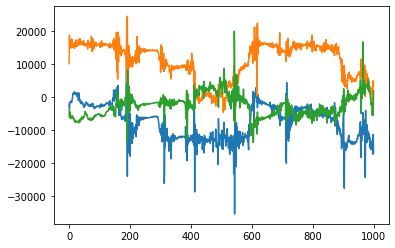

In [7]:
plt.plot(arr[:,:1000].T)

In [8]:
arr.shape

(3, 786432)

In [9]:
freqencies, power, wavelet_transform = wavelet_transform(X=arr.T, n_freqs=25, fsample=35, fmin=1., fmax=15., n_jobs=15)

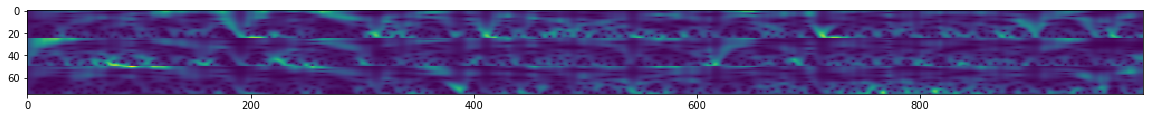

In [10]:
plt.figure(figsize=(20,25))
plt.imshow(wavelet_transform[0:1000].T)

In [11]:
reducer = umap.UMAP(metric='manhattan')

In [12]:
random_indices = np.random.choice(len(wavelet_transform), 50000)
embedding = reducer.fit_transform(wavelet_transform[random_indices])

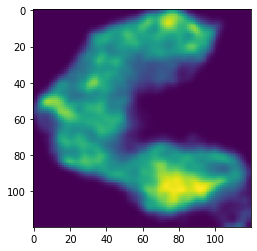

In [13]:
H, XE, YE = np.histogram2d(embedding[:,0], embedding[:,1], bins=120)
H = ndimage.filters.gaussian_filter(H, sigma=2)
plt.imshow(H, cmap='viridis')

In [14]:
k=6
model = mixture.GaussianMixture(n_components=k, covariance_type='diag', max_iter=1000)

NameError: name 'mixture' is not defined

In [15]:
def get_eigvals_shuffle(samples):
    '''
    TODO: add doc-string
    '''
    print('calculating eigen values for shuffled data')
#     samplesPCA = StandardScaler().fit_transform(samples.T)
    #samplesPCA = scale(samples.T)
    for i in range(samples.shape[1]):
        np.random.shuffle(samples[:,i])
    covmat = np.cov(samples)
    eigenvals, eigvecs = LA.eig(covmat)
    #pca2 = PCA(n_components=samplesPCA1.shape[0]).fit(samplesPCA1)
    return eigenvals.real

def get_eigvals(samples):
    '''
    TODO: add doc-string
    '''
    print('calculating eigen values for real data')
#     samplesPCA = StandardScaler().fit_transform(samples.T)
    #samplesPCA = scale(samples.T)
    #pca1 = PCA(n_components=samplesPCA2.shape[0]).fit(samplesPCA2)
    covmat = np.cov(samples)
    eigenvals, eigvecs = LA.eig(covmat)
    return eigenvals.real, eigvecs

def find_eig_cutoff(samples):
    '''
    TODO: add doc-string
    '''
    eigvals_shuff = get_eigvals_shuffle(samples)
    eigvals, eigvecs = get_eigvals(samples)
    
    shuf=np.array([(i,eigvals_shuff[i])for i in range(len(eigvals_shuff))])
    samp=np.array([(i,eigvals[i])for i in range(len(eigvals))])
    x,_  = find_intersection(shuf, samp)
    print(x)
    print(_)
    x = int(np.max(x))
    return eigvals, eigvals_shuff, x



def find_intersection(A, 
                      B):
    '''
    TODO: add doc-string
    '''
    # min, max and all for arrays
    amin = lambda x1, x2: np.where(x1<x2, x1, x2)
    amax = lambda x1, x2: np.where(x1>x2, x1, x2)
    aall = lambda abools: np.dstack(abools).all(axis=2)
    slope = lambda line: (lambda d: d[:,1]/d[:,0])(np.diff(line, axis=0))

    x11, x21 = np.meshgrid(A[:-1, 0], B[:-1, 0])
    x12, x22 = np.meshgrid(A[1:, 0], B[1:, 0])
    y11, y21 = np.meshgrid(A[:-1, 1], B[:-1, 1])
    y12, y22 = np.meshgrid(A[1:, 1], B[1:, 1])

    m1, m2 = np.meshgrid(slope(A), slope(B))
    m1inv, m2inv = 1/m1, 1/m2

    yi = (m1*(x21-x11-m2inv*y21) + y11)/(1 - m1*m2inv)
    xi = (yi - y21)*m2inv + x21

    xconds = (amin(x11, x12) < xi, xi <= amax(x11, x12), 
              amin(x21, x22) < xi, xi <= amax(x21, x22) )
    yconds = (amin(y11, y12) < yi, yi <= amax(y11, y12),
              amin(y21, y22) < yi, yi <= amax(y21, y22) )

    return xi[aall(xconds)], yi[aall(yconds)]



In [ ]:
samples = np.copy(wavelet_transform[random_indices])
samplesPCA = StandardScaler().fit_transform(samples)
eigvals, eigvecs = get_eigvals(samples)
samples_shuffled = np.copy(samples)
for i in range(samples_shuffled.shape[1]):
        np.random.shuffle(samples_shuffled[:,i])
eigvals_shuff, eigvecs_shuff = get_eigvals(samples_shuffled)
shuf=np.array([(i,eigvals_shuff[i])for i in range(len(eigvals_shuff))])
samp=np.array([(i,eigvals[i])for i in range(len(eigvals))])
x,_  = find_intersection(shuf, samp)
x = int(np.max(x))
print(x)
plt.plot([i for i in range(0,len(eigvals[1:x+1]))],eigvals[1:x+1], '.-',color='g', lw=1.5, label='real data (used)')
plt.plot([i+len(eigvals[1:x])+1 for i in range(0,len(eigvals[x+1:2*x]))],eigvals[x+1:2*x], '.-',color='k', alpha=0.5,lw=0.5, label='real data (unused)')
plt.plot(eigvals_shuff[1:2*x],'.-', color='b', alpha=0.5,lw=0.5, label='randomly shuffled data')
plt.yscale('log')
plt.xlabel('principal component')
plt.ylabel('log eigenvalue')
plt.legend()

calculating eigen values for real data


In [ ]:
def GMM_fit(k, X):
    print('fitting model with {} clusters @ {}'.format(k, time.time()))
    clf = mixture.GaussianMixture(n_components=k, covariance_type='diag', max_iter=1000)
    clf.fit(X)
    return clf.bic(X)
    
def GMM_helper(args):
    return GMM_fit(*args)

def norm_diff_bic(bic, K):
    ks = [k for k in range(1,K)]
    C1 = ((np.max(ks)-np.min(ks))*(bic-np.min(bic)))/(np.max(bic)-np.min(bic))
    Cm = C1/ks
    C2 = ((np.max(ks)-np.min(ks))*(Cm-np.min(Cm)))/(np.max(Cm)-np.min(Cm))
    DiffBic = abs(C1-C2)/2
    return C1, DiffBic, Cm, C2

def iterate_clusters(X, K=10):
    pool = Pool(processes=1)
    inputs = [(k, X) for k in range(1,K)]
    data = pool.map(GMM_helper, inputs, chunksize = 1)
    pool.close()
    pool.join()
    gc.collect()
    C1, DiffBic, Cm, C2 = norm_diff_bic(data, K)
    ret_k = [k for k in range(1,K)]
    return ret_k, data, C1, DiffBic, Cm, C2, ret_k[np.argmax(DiffBic)]

In [46]:
samples = np.copy(wavelet_transform)
samplesPCA = StandardScaler().fit_transform(samples)
X = PCA(n_components=15).fit_transform(samplesPCA.T)

In [ ]:
K, raw_bic, C1, DiffBic, Cm, C2, opt = iterate_clusters(X.T, K=10)

In [7]:
# don't try this on colab (only 2 cores)
# tsne = TSNE(n_components=2, n_jobs=-1)
# X_embedded = tsne.fit_transform(features.T)

/home/ngwena-ian/Documents/Git/ASAB-2019-MLWS/utils.py:150: ComplexWarning: Casting complex values to real discards the imaginary part
  x = int(np.max(x))
/home/ngwena-ian/miniconda3/envs/models/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


998


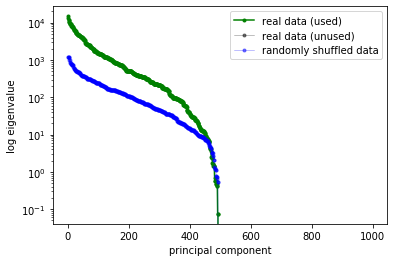

In [39]:
# features = np.load(os.path.join(OUTPUT_DIR, 'wavelet_features.npy'))
find_eigvalue_cutoff(features[0:1000])

36


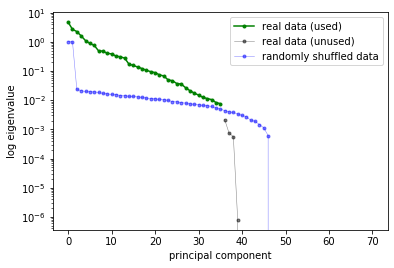

In [ ]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
import gc

import numba
import numpy as np
import numpy.ma as ma
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import mixture
from scipy import linalg as LA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from multiprocessing import Pool
import time

import glob
import h5py
from scipy import sparse
from scipy import ndimage

from MulticoreTSNE import MulticoreTSNE as TSNE

import scipy.cluster as cl
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
import tensorflow as tf